In [7]:
import pandas as pd
# !curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from collections import Counter
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch import optim
from torch import nn
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import os
import string
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle

In [8]:
class AnimeClassifierModel(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_classes,
                 n_layers, dropout=0.3, bidirectional=True) -> None:
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
        )
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.classifier = nn.Linear(lstm_output_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        # Check the shape of the inputs
        # print(f"Input shape: {inputs.shape}")

        embeddings = self.embedding(inputs)

        # Check the shape after embedding
        # print(f"Embedding shape: {embeddings.shape}")

        lstm_output, _ = self.lstm(embeddings)

        # Check the shape of the LSTM output
        # print(f"LSTM output shape: {lstm_output.shape}")

        last_output = lstm_output[:, -1, :]  # Extract last timestep output
        last_output = self.dropout(last_output)

        # Check the shape after dropout
        # print(f"Last output shape: {last_output.shape}")

        logits = self.classifier(last_output)
        return logits


In [9]:
# 데이터 로드 함수
def load_data(train_path):
    trainDF = pd.read_csv(train_path, encoding='utf8')
    trainDF = trainDF.drop(trainDF.index[:15])
    trainDF['age_id'] = trainDF['age_id'].map(lambda x: 0 if x < 2 else x-1 )
    X_train, X_test, y_train, y_test = train_test_split(trainDF[['story']],trainDF['age_id'],stratify=trainDF['age_id'],test_size=0.2,random_state=10)
    return X_train, X_test, y_train, y_test

# 전처리 함수
def preprocess_text(text, punc):
    # 구두점 제거
    for p in punc:
        text = text.replace(p, '')
    # 한글과 공백만 남기기
    text = re.sub('[^ ㄱ-ㅣ가-힣]+', ' ', text)
    return text

# 토큰화 및 불용어 제거 함수
def tokenize_and_remove_stopwords(tokenizer, texts, stop_words):
    tokens = [tokenizer.morphs(text) for text in texts]
    tokens = [[token for token in doc if token not in stop_words] for doc in tokens]
    return tokens

# 단어사전 구축 함수
def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens.copy()
    vocab += [token for token, _ in counter.most_common(n_vocab)]
    return vocab

# 인코딩 함수
def encoding_ids(token_to_id, tokens, unk_id):
    return [[token_to_id.get(token, unk_id) for token in doc] for doc in tokens]

# 패딩 함수
def pad_sequences(sequences, max_length, pad_value):
    result = []
    for seq in sequences:
        seq = seq[:max_length]
        pad_len = max_length - len(seq)
        padded_seq = seq + [pad_value] * pad_len
        result.append(padded_seq)
    return np.array(result)

def save_vocab(vocab,save_file):
    # vocab 저장
    with open(save_file, 'wb') as f:
        pickle.dump(vocab, f)

# 클래스 가중치 계산 함수
def calculate_class_weights(labels, num_classes, device):
    print(num_classes)
    class_counts = np.bincount(labels, minlength=num_classes)  # num_classes만큼 길이를 강제 설정
    total_samples = len(labels)
    class_weights = total_samples / (num_classes * class_counts)  # 총개수 / 각 클래스별 개수 가중치 설정
    return torch.tensor(class_weights, dtype=torch.float32).to(device)

In [23]:
# 학습 함수
def model_train(model, train_loader, cl_criterion, optimizer, device, interval):
    model.train()
    losses = []
    accuracies = []

    for step, (input_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)

        # 모델 예측
        classesd = model(input_ids)

        # 손실 계산
        loss = cl_criterion(classesd, labels)         # 다중 분류 손실
        losses.append(loss.item())

        # 정확도 계산
        predictions = torch.argmax(classesd, dim=1)  # CrossEntropyLoss 사용 시 softmax 불필요
        accuracy = (predictions == labels).float().mean().item()
        accuracies.append(accuracy)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0 and step != 0:
            mean_loss = np.mean(losses)
            mean_accuracy = np.mean(accuracies)
            print(f'Train Step {step}, Loss: {mean_loss:.4f}, Accuracy: {mean_accuracy:.4f}')
            losses = []
            accuracies = []

# 테스트 함수
def model_test(model, test_loader, cl_criterion, device):
    model.eval()
    losses = []
    cl_true = []
    cl_pred = []

    with torch.no_grad():
        for step, (input_ids, labels) in enumerate(test_loader):
            input_ids = input_ids.to(device)

            # 모델 예측
            classesd = model(input_ids)

            # 손실 계산
            loss = cl_criterion(classesd, labels)
            losses.append(loss.item())

            # 다중 분류 예측
            cl_predictions = torch.argmax(classesd, dim=1)
            cl_true.extend(labels.cpu().numpy())
            cl_pred.extend(cl_predictions.cpu().numpy())

    # 손실 평균 계산
    avg_loss = np.mean(losses)

    # F1 스코어 계산
    cl_f1 = f1_score(cl_true, cl_pred, average='weighted')

    # # 혼동 행렬 시각화
    # cm = confusion_matrix(cl_true, cl_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap=plt.cm.Blues)
    # plt.show()

    # 클래스 예측 분포 확인
    unique, counts = np.unique(cl_pred, return_counts=True)
    print("Class predictions distribution:", dict(zip(unique, counts)))

    # F1 스코어와 정확도 출력
    print(f'Val Loss: {avg_loss:.4f}')
    print(f'Class F1 Score: {cl_f1:.4f}')

    # 상세 보고서 출력
    print("\nClass Classification Report:\n", classification_report(cl_true, cl_pred))

    return cl_f1, avg_loss

# 하이퍼파라미터 설정
N_VOCAB = 5000
MAX_LENGTH = 60
EPOCHS = 500
INTERVAL = 500
BATCH_SIZE = 16
LR = 0.001
special_tokens = ['<pad>', '<unk>']


# 데이터 로드
DATA_PATH = 'anime_data.csv'
print("Training data path:", DATA_PATH)
X_train, X_test, y_train, y_test = load_data(DATA_PATH)
X_train = X_train.astype('object')
X_test = X_test.astype('object')
# 전처리: 구두점 제거 및 특수문자 제거
punc = string.punctuation
X_train['story'] = X_train['story'].map(lambda x: preprocess_text(str(x), punc))
X_test['story'] = X_test['story'].map(lambda x: preprocess_text(str(x), punc))

# 불용어 로드
STOP_WORD =  'stopwords.txt'
with open(STOP_WORD, 'r', encoding='utf-8') as f:
    stop_words = set([line.strip() for line in f])

# 토큰화 및 불용어 제거
tokenizer = Okt()
train_tokens = tokenize_and_remove_stopwords(tokenizer, X_train['story'], stop_words)
test_tokens = tokenize_and_remove_stopwords(tokenizer, X_test['story'], stop_words)

# 단어 사전 구축
vocab = build_vocab(train_tokens, N_VOCAB, special_tokens)
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

# 인코딩 및 패딩
pad_id = token_to_id['<pad>']
unk_id = token_to_id['<unk>']
train_ids = encoding_ids(token_to_id, train_tokens, unk_id)
test_ids = encoding_ids(token_to_id, test_tokens, unk_id)
train_ids = pad_sequences(train_ids, MAX_LENGTH, pad_id)
test_ids = pad_sequences(test_ids, MAX_LENGTH, pad_id)

Training data path: anime_data.csv


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 텐서화
train_ids = torch.tensor(train_ids, dtype=torch.long).to(device)  # GPU로 이동
test_ids = torch.tensor(test_ids, dtype=torch.long).to(device)    # GPU로 이동

# 레이블 텐서화
train_labels = torch.tensor(y_train.values, dtype=torch.long).to(device)  # GPU로 이동
test_labels = torch.tensor(y_test.values, dtype=torch.long).to(device)    # GPU로 이동

# 데이터셋 생성
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

# 클래스 가중치 계산
train_labels_np = y_train.values # 수정: y_train을 사용
# class_weights = calculate_class_weights(train_labels_np, y_train.unique().shape[0], device)
# print("Scaled Class Weights:", class_weights)

# 각 클래스의 지원(Support) 수에 반비례하는 가중치 설정
class_weights = torch.tensor([1/266, 1/81, 1/329, 1/92], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 샘플 가중치 계산 및 WeightedRandomSampler 생성
# sample_weights = class_weights[train_labels_np].cpu()
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 데이터 로더 생성
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# 모델 초기화
n_vocab = len(token_to_id)
hidden_dim = 128
embedding_dim = 128
n_layers = 3
classifier = AnimeClassifierModel(
    n_vocab=n_vocab,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_classes=y_train.unique().shape[0],
    n_layers=n_layers,
    dropout=0.2
).to(device)  # 모델을 GPU로 이동

# 손실 함수 및 옵티마이저 설정
cl_criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)  # GPU로 이동
# cl_criterion = nn.CrossEntropyLoss().to(device)  # GPU로 이동
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001, alpha=0.99, eps=1e-08)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# 조기 종료 및 모델 저장을 위한 변수 초기화
best_f1 = 0.0
epochs_no_improve = 0
n_epochs_stop = 10  # 조기 종료를 위한 patience

# 모델 저장 디렉토리 생성
SAVE_PATH = r'./models/'
SAVE_VOCAB = os.path.join(SAVE_PATH, 'ani_vocab.pkl')
SAVE_FILE = os.path.join(SAVE_PATH, 'ani_model.pth')
SAVE_MODEL = os.path.join(SAVE_PATH, 'ani_model_full.pth')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
save_vocab(vocab, SAVE_VOCAB)
f1_history = []
loss_history = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')

    # train() 함수와 test() 함수에서 텐서를 GPU로 이동하는지 확인 필요
    model_train(classifier, train_loader, cl_criterion, optimizer, device, INTERVAL)
    current_f1, current_loss = model_test(classifier, test_loader, cl_criterion,device)
    f1_history.append(current_f1)
    loss_history.append(current_loss)

    # 학습률 스케줄러 업데이트
    scheduler.step(current_loss)

    # F1 스코어가 개선되었는지 확인
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_no_improve = 0
        # 모델 저장
        torch.save(classifier.state_dict(), SAVE_FILE)
        torch.save(classifier, SAVE_MODEL)

        
        print(f'F1 Score improved to {current_f1:.4f}. Model saved.')
    else:
        epochs_no_improve += 1
        print(f'No improvement in F1 Score for {epochs_no_improve} epochs.')

    # 조기 종료 조건
    if epochs_no_improve >= n_epochs_stop:
        print("Early stopping triggered.")
        break

# 결과 저장
SAVEDF = pd.DataFrame({'f1_score': f1_history, 'loss': loss_history})
SAVEDF.to_csv(r'./score_loss_history.csv')

C:\Users\KDP-38\AppData\Local\Temp\ipykernel_7824\3462635351.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ids = torch.tensor(train_ids, dtype=torch.long).to(device)  # GPU로 이동
C:\Users\KDP-38\AppData\Local\Temp\ipykernel_7824\3462635351.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ids = torch.tensor(test_ids, dtype=torch.long).to(device)    # GPU로 이동
c:\Users\KDP-38\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/500
Class predictions distribution: {0: 516, 1: 31, 2: 221}
Val Loss: 1.3593
Class F1 Score: 0.3984

Class Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.83      0.56       266
           1       0.26      0.10      0.14        81
           2       0.55      0.37      0.44       329
           3       0.00      0.00      0.00        92

    accuracy                           0.45       768
   macro avg       0.31      0.32      0.29       768
weighted avg       0.41      0.45      0.40       768

F1 Score improved to 0.3984. Model saved.
Epoch 2/500


c:\Users\KDP-38\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KDP-38\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KDP-38\anaconda3\envs\TEXT_018_230_38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Class predictions distribution: {0: 426, 1: 42, 2: 270, 3: 30}
Val Loss: 1.3001
Class F1 Score: 0.4467

Class Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.73      0.56       266
           1       0.33      0.17      0.23        81
           2       0.54      0.44      0.49       329
           3       0.33      0.11      0.16        92

    accuracy                           0.47       768
   macro avg       0.42      0.36      0.36       768
weighted avg       0.46      0.47      0.45       768

F1 Score improved to 0.4467. Model saved.
Epoch 3/500
Class predictions distribution: {0: 371, 1: 56, 2: 268, 3: 73}
Val Loss: 1.3328
Class F1 Score: 0.4569

Class Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.67      0.56       266
           1       0.25      0.17      0.20        81
           2       0.55      0.45      0.50       329
           3       0.29   

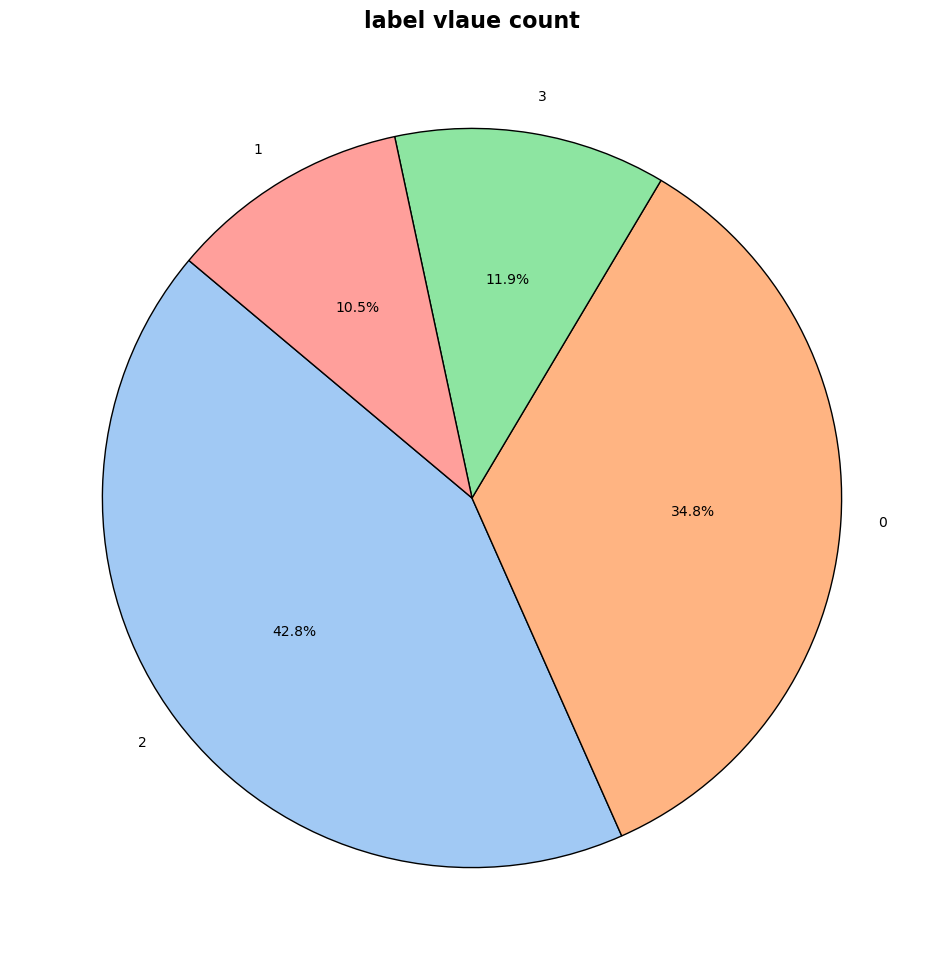

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예제 데이터 시리즈 생성
labels = y_train

# value_counts를 사용하여 레이블의 빈도 계산
label_counts = labels.value_counts()

# 파이차트 스타일 설정
plt.figure(figsize=(12, 12))  # 그래프 크기 설정
colors = sns.color_palette('pastel')  # 파스텔 색상 팔레트 적용

# 파이차트 생성
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',  # 퍼센티지 표시
    startangle=140,     # 시작 각도 설정
    colors=colors,      # 파스텔 색상 사용
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}  # 구분선 스타일 추가
)

# 그래프 제목 설정
plt.title('label vlaue count', fontsize=16, fontweight='bold')

# 그래프 보여주기
plt.show()


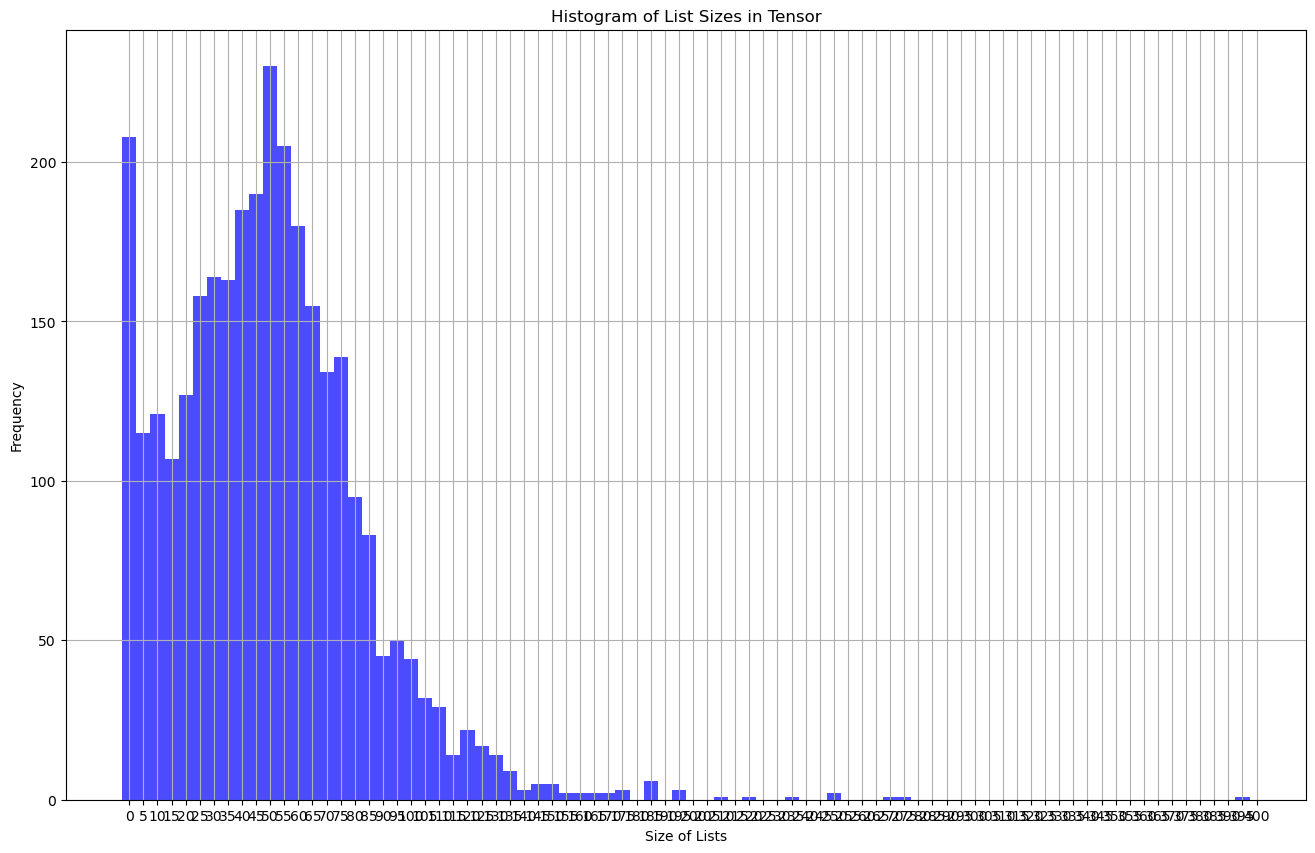

In [55]:
import matplotlib.pyplot as plt

# 리스트의 크기를 구합니다.
list_sizes = [len(lst) for lst in train_tokens]

# 히스토그램 그리기
plt.figure(figsize=(16, 10))

# 블록으로 나누기 위해 bins을 조정합니다.
plt.hist(list_sizes, bins=range(0, max(list_sizes) + 5, 5), align='left', alpha=0.7, color='blue')

plt.title('Histogram of List Sizes in Tensor')
plt.xlabel('Size of Lists')
plt.ylabel('Frequency')
plt.xticks(range(0, max(list_sizes) + 5, 5))  # x축 눈금을 리스트 크기로 설정 (5 간격)
plt.grid(True)
plt.show()


   Unnamed: 0  f1_score      loss
0           0  0.247292  1.382962
1           1  0.299997  1.391683
2           2  0.352137  1.484646
3           3  0.403300  1.373043
4           4  0.560023  1.464819


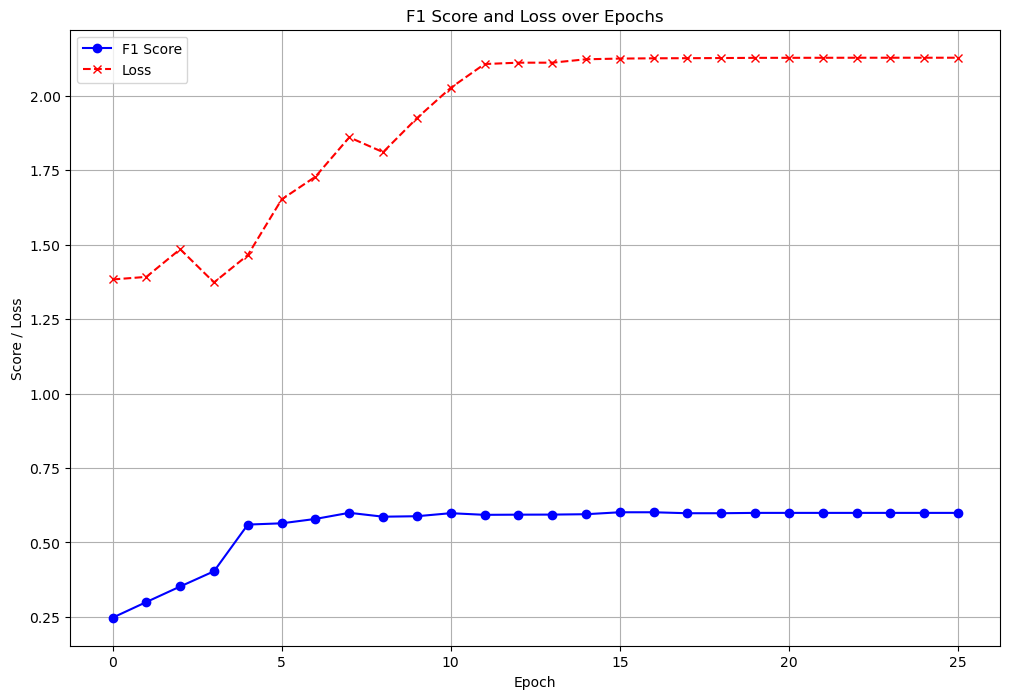

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 불러오기 (파일 경로에 맞게 수정)
data = pd.read_csv('score_loss_history.csv')

# 데이터 구조 확인
print(data.head())  # f1_score와 loss 열이 포함되어 있는지 확인

# 그래프 스타일 설정
plt.figure(figsize=(12, 8))

# f1_score 선 그래프
plt.plot(data['f1_score'], label='F1 Score', color='b', linestyle='-', marker='o')

# loss 선 그래프
plt.plot(data['loss'], label='Loss', color='r', linestyle='--', marker='x')

# 그래프 제목과 라벨 설정
plt.title('F1 Score and Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score / Loss')
plt.legend()  # 범례 추가

# 그래프 보여주기
plt.grid(True)
plt.show()